# Analysing New York City airbnb trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Importing and cleaning the data

[![png](images/nyc_airbnb.png)](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)

We'll use an open source dataset from Kaggle that contains New York's Airbnb data for 2019.

In [2]:
airbnb = pd.read_csv('airbnb.csv', usecols = ['neighbourhood','neighbourhood_group', 'reviews_per_month',
                                              'availability_365','price', 'room_type', 'last_review'])

display(airbnb.head(10))

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355
2,Manhattan,Harlem,Private room,150,NaN,NaN,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129
6,Brooklyn,Bedford-Stuyvesant,Private room,60,2017-10-05,0.40,0
7,Manhattan,Hell's Kitchen,Private room,79,2019-06-24,3.47,220
8,Manhattan,Upper West Side,Private room,79,2017-07-21,0.99,0
9,Manhattan,Chinatown,Entire home/apt,150,2019-06-09,1.33,188


<br>Uppon a quick inspection of the dataset we can find several Nan values in different columns. NaNs tend to be a problem while handling datasets; let's see how widespread they are accross ours:

In [3]:
print(airbnb.isnull().sum())

neighbourhood_group        0
neighbourhood              0
room_type                  0
price                      0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64


<br>There are more than ten thousand NaN values in both the *last_review* column and the *reviews per moth* column. Let's find out how much that is compared to the total number of lines:

In [4]:
print('{:.2f} % NaN values'.format(airbnb.isnull().sum().reviews_per_month*100/len(airbnb)))

20.56 % NaN values


We have some ways of dealing with the NaN problem, just to name a few:
- Study where they are coming from; see if they are from a particular neighborhood or if they are split amongst all of them.
- Replace the NaN values with the mean value for that column for their neighborhood.
- Replace the NaN values with the global mean value for that column
- Discard the columns with the NaN values.
- Discard the rows with the NaN values.

Most of them would be time consuming, and dealing with NaNs is not the topic of this notebook. In this case, we'll just discard every row that has a NaN value:

In [5]:
airbnb.dropna(inplace=True)

<br>Another good practice is to look for duplicates:

In [8]:
print(airbnb.duplicated().sum())

9


We'll discard these rows:

In [9]:
airbnb.drop_duplicates(inplace = True)

<br>Now we'll lock for outliers in the data; values really out of place or just plainly wrong. This is easy to do through a boxplot:

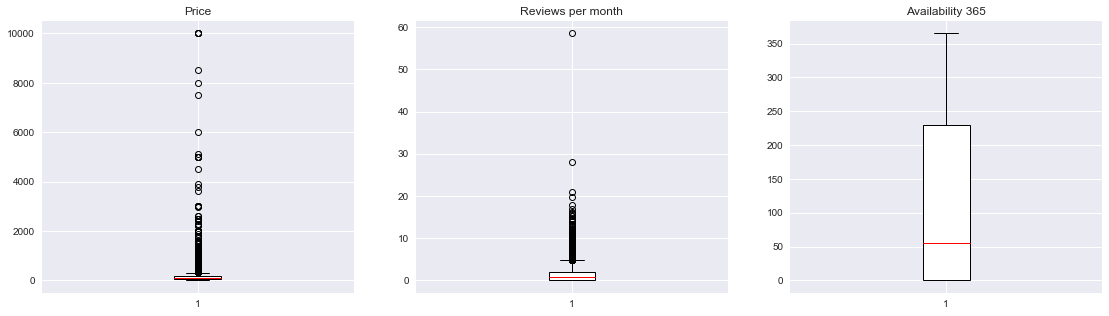

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
columns = ['price', 'reviews_per_month', 'availability_365']
for column, ax in zip(columns, axs):
    box = ax.boxplot(airbnb[column], patch_artist=True)
    ax.set_title(column.replace('_', ' ').capitalize())
    # styling
    plt.setp(box['boxes'], color='white')
    plt.setp(box['boxes'], edgecolor='black')
    plt.setp(box['medians'], color='red')
plt.show()

The *availability* column looks fine; the *price* one, even with its high prices, seems reasonable too (there are some really expensive apartments in NY); but if we take a closer look at the *reviews per month* column we'll be able to see how one apartment has almost 60 reviews per month. And unless that apartment is close to a black hole that distorts time making one day there two days in real life, months have 31 days at max.

*Note: Last time I checked, Airbnb reservations are made by one person only and you have to book the place for the night, hence the consideration of that value as an outlier.*

We'll get rid of that outlier:

In [17]:
airbnb = airbnb[airbnb.reviews_per_month != airbnb['reviews_per_month'].max()]

### 1. Barrio de Williamsburg 

<i>El barrio de Williamsburg es uno de los barrios de moda hoy en día. Desde 2005 ha pasado de ser
un distrito donde principalmente se encontraban fabricas a acoger una gran cantidad de gente joven y nuevos
negocios. ¿Teniendo en cuenta los datos proporcionados que posición en términos de popularidad/calidad se
puede decir que ostenta el barrio con respecto a los demás que forma New York?</i>

El primer paso es clasificar los datos en funcion de las reseñas por mes y la disponibilidad.

In [18]:
# Se crea una nueva columna para albergar la etiqueta
airbnb['reviews_tag'] = ''

# Se obtienen los valores necesarios para dividir los datos en 3 cuartiles
quantiles = airbnb['reviews_per_month'].quantile([0.33, 0.66])

# Se hace una division en 3 grupos de igual numero de ocurrencias
airbnb.loc[(airbnb.reviews_per_month > 0 ) & (airbnb.reviews_per_month <= quantiles.values[0]), 'reviews_tag'] = 'Baja'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[0] ) & (airbnb.reviews_per_month <= quantiles.values[1]), 'reviews_tag'] = 'Media'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[1] ), 'reviews_tag'] = 'Alta'

In [19]:
# Se crea una nueva columna para albergar la etiqueta
airbnb['availability_tag'] = ''

# Se obtienen los valores necesarios para dividir los datos en 3 cuartiles
quantiles = airbnb['availability_365'].quantile([0.33, 0.66])

# Se hace una division en 3 grupos de igual numero de ocurrencias
airbnb.loc[(airbnb.availability_365 <= quantiles.values[0]), 'availability_tag'] = 'Poco disponible'
airbnb.loc[(airbnb.availability_365 > quantiles.values[0] ) & (airbnb.availability_365 <= quantiles.values[1]), 'availability_tag'] = 'Disponible normalmente'
airbnb.loc[(airbnb.availability_365 > quantiles.values[1] ), 'availability_tag'] = 'Altamente disponible'

In [20]:
# Relacion reseñas-disponibilidad

# Se crea una nueva columna para albergar la etiqueta de clasificacion
airbnb['classification'] = ''

# Se relacionan las columnas reviews_tag y avalibility_tag para obtener el valor de classification según las instrucciones del enunciado
airbnb.loc[(airbnb['reviews_tag'] == 'Baja') & (airbnb['availability_tag'] == 'Poco disponible'), 'classification'] = 'Bueno'
airbnb.loc[(airbnb['reviews_tag'] == 'Media') & (airbnb['availability_tag'] == 'Poco disponible'), 'classification'] = 'Bueno'
airbnb.loc[(airbnb['reviews_tag'] == 'Alta') & (airbnb['availability_tag'] == 'Poco disponible'), 'classification'] = 'Muy bueno'

airbnb.loc[(airbnb['reviews_tag'] == 'Baja') & (airbnb['availability_tag'] == 'Disponible normalmente'), 'classification'] = 'Regular'
airbnb.loc[(airbnb['reviews_tag'] == 'Media') & (airbnb['availability_tag'] == 'Disponible normalmente'), 'classification'] = 'Regular'
airbnb.loc[(airbnb['reviews_tag'] == 'Alta') & (airbnb['availability_tag'] == 'Disponible normalmente'), 'classification'] = 'Bueno'

airbnb.loc[(airbnb['reviews_tag'] == 'Baja') & (airbnb['availability_tag'] == 'Altamente disponible'), 'classification'] = 'Malo'
airbnb.loc[(airbnb['reviews_tag'] == 'Media') & (airbnb['availability_tag'] == 'Altamente disponible'), 'classification'] = 'Malo'
airbnb.loc[(airbnb['reviews_tag'] == 'Alta') & (airbnb['availability_tag'] == 'Altamente disponible'), 'classification'] = 'Muy malo'

Se inspecciona el dataframe para comprobar que los cambios se han llevado a cabo correctamente:

In [21]:
airbnb.head(20)

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365,reviews_tag,availability_tag,classification
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365,Baja,Altamente disponible,Malo
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355,Media,Altamente disponible,Malo
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194,Alta,Altamente disponible,Muy malo
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0,Baja,Poco disponible,Bueno
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129,Media,Disponible normalmente,Regular
6,Brooklyn,Bedford-Stuyvesant,Private room,60,2017-10-05,0.40,0,Media,Poco disponible,Bueno
7,Manhattan,Hell's Kitchen,Private room,79,2019-06-24,3.47,220,Alta,Altamente disponible,Muy malo
8,Manhattan,Upper West Side,Private room,79,2017-07-21,0.99,0,Media,Poco disponible,Bueno
9,Manhattan,Chinatown,Entire home/apt,150,2019-06-09,1.33,188,Media,Altamente disponible,Malo
10,Manhattan,Upper West Side,Entire home/apt,135,2019-06-22,0.43,6,Media,Disponible normalmente,Regular


Se extraen los barrios del distrito de Brooklyn y su clasificación (dada la cantidad de barrios en Brooklyn, solo se compara con el top 10):

In [22]:
brooklyn = airbnb.loc[airbnb.neighbourhood_group == 'Brooklyn', :]

# Los barrios de Brooklyn con más reviews
top_10 = brooklyn['neighbourhood'].value_counts()[:10]

# Nombres de los barrios
top_10_nombres = top_10.index

# Numero de reviews
top_10_nreviews = top_10.values

In [23]:
# El siguiente fragmento de codigo extrae las reviews del top 10 y las introduce en una lista para su posterior representacion en un grafico.
puntuaciones = []
for barrio in top_10_nombres:
    # Por cada barrio en el top 10, se extrae el número de clasificaciones de cada tipo:
    reviews = airbnb.loc[airbnb.neighbourhood == barrio, 'classification'].value_counts().reindex(['Muy bueno', 'Bueno', 'Regular', 'Malo', 'Muy malo']).values
    puntuaciones.append(reviews)
puntuaciones = np.array(puntuaciones)

# Puntuaciones normalizadas para su posterior representacion
puntuaciones_norm = puntuaciones * 100 / puntuaciones.sum(axis=1)[:, None]

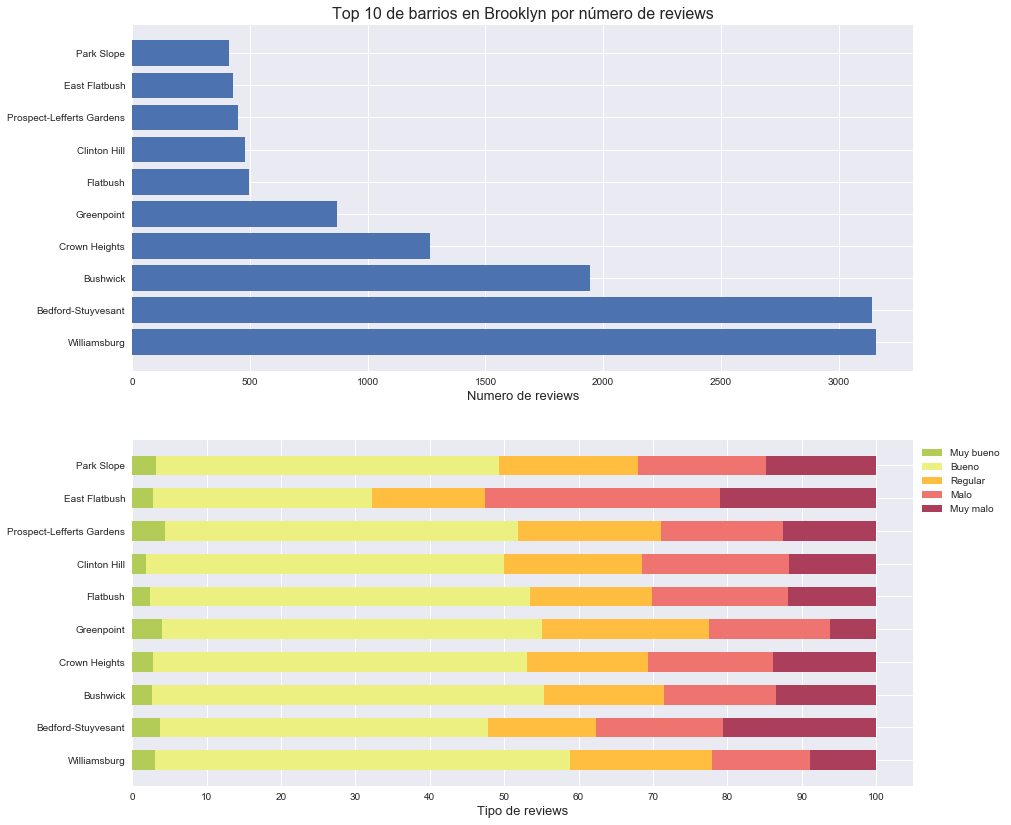

In [24]:
fig, ax = plt.subplots(2,1, figsize = (14,14))
# Grafica con el numero de reviews
ax[0].barh(top_10_nombres, top_10_nreviews)
ax[0].set_xlabel('Numero de reviews', fontsize = 13)
ax[0].set_title('Top 10 de barrios en Brooklyn por número de reviews', fontsize = 16)

# Grafica con el tipo de reviews por barrio
puntuaciones_norm_cum = puntuaciones_norm.cumsum(axis=1)
colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
for i, (reviews, color) in enumerate(zip(puntuaciones, colors)):
    if i<5:
        widths = puntuaciones_norm[:,i]
        starts = puntuaciones_norm_cum[:,i] - widths
        ax[1].barh(top_10_nombres, widths, left = starts, height = 0.6, color = color)

ax[1].legend(['Muy bueno', 'Bueno', 'Regular','Malo','Muy malo'],
             loc = 'best', bbox_to_anchor = (1,1))
ax[1].set_xlabel('Tipo de reviews', fontsize = 13)
ax[1].set_xticks(np.arange(0,110,10))
plt.show()

En la primera de las anteriores gráficas que recogen el top 10 de barrios en Brooklyn, elegidos en función al número de reviews, se puede apreciar como Williamsburg es el que mayor número de reviews amasa, superando por poco al barrio de Bedford-Stuyvesant.
<br>Si bien ambos barrios están cerca en cuanto al número de reviews, en la segunda gráfica se muestran claramente diferenciados; el porcentaje de reviews no negativas de Williamsburg es casi un 20% superior al de Bedford, cuyas reviews negativas alcanzan casi un 40% del total.
<br>Hay dos casos de interés en la segunda gráfica; Williamsburg, por ser el barrio con mayor número de reviews y mayor proporción de reviews positivas frente al total, e East Flatbush, donde el número de reviews negativas superan al de positivas.

### 2. Los 5 barrios más populares

<i>Explica visualmente como se distribuyen los 5 barrios más populares (esto serán aquellos cuyos
apartamentos estén más solicitados en números absolutos). Para ello utiliza un diagrama de burbuja donde el
eje de las X indica el barrio y el eje Y la calidad de los apartamentos. Usa todos los diagramas que necesites
para llegar a esta conclusión final.</i>

<br>Se agrupan los barrios por clasificación y se conservan aquellos 5 con más reviews del tipo "Muy bueno":

In [16]:
# La siguiente linea de codigo agrupa por 'neighbourhood' y cuenta el numero de ocurrencias de cada
# clasificación para después pivotar el indice stackeado y convertirlo en columnas, rellenando los
# valores ausentes con ceros
datos_barrios = airbnb.groupby('neighbourhood')['classification'].value_counts().unstack().fillna(0)
# Se filtra por número de ocurrencias de 'Muy bueno' y se cogen a los 5 primeros
top_5 = datos_barrios.sort_values(by='Muy bueno', ascending = False)[:5]
# Se ordenan las columnas para mayor claridad
top_5 = top_5[['Muy bueno', 'Bueno', 'Regular', 'Malo', 'Muy malo']]
top_5

classification,Muy bueno,Bueno,Regular,Malo,Muy malo
neighbourhood,,,,,
Bedford-Stuyvesant,117.0,1384.0,455.0,540.0,645.0
Williamsburg,97.0,1764.0,599.0,416.0,283.0
Harlem,81.0,1002.0,384.0,417.0,322.0
East Harlem,52.0,467.0,147.0,137.0,141.0
Upper West Side,51.0,742.0,254.0,313.0,122.0


<br>Se obtienen los valores medios relevantes de cada barrio del top 5 (precio, número de reviews mensuales y disponibilidad):

In [17]:
# Se agrupa por 'neighbourhood' y 'classification', obteniendo la media del resto de columnas y acotando únicamente al top 5
datos_top_5 = airbnb.groupby(['neighbourhood', 'classification']).mean()
datos_top_5 = datos_top_5.loc[list(top_5.index),:]
datos_top_5

price  reviews_per_month  \
neighbourhood      classification                                  
Bedford-Stuyvesant Bueno            97.705202           1.440918   
                   Malo            118.788889           0.610815   
                   Muy bueno        80.991453           2.749145   
                   Muy malo        114.758140           3.001256   
                   Regular         109.784615           0.643934   
East Harlem        Bueno           135.644540           1.706510   
                   Malo            138.109489           0.634088   
                   Muy bueno       102.288462           3.279038   
                   Muy malo        143.063830           2.990071   
                   Regular         119.462585           0.701633   
Harlem             Bueno            99.512974           1.328054   
                   Malo            134.755396           0.543285   
                   Muy bueno        93.888889           2.587654   
                   Muy malo        127.177019           2.934534   
                   Regular         140.229167           0.636589   
Upper West Side    Bueno           155.208895           0.933518   
                   Malo            256.527157           0.427572   
                   Muy bueno       118.705882           2.637451   
                   Muy malo        193.975410           3.148197   
                   Regular         202.295276           0.559764   
Williamsburg       Bueno           123.576531           1.002177   
                   Malo            163.973558           0.540601   
                   Muy bueno       122.278351           2.419485   
                   Muy malo        185.812721           3.090883   
                   Regular         152.343907           0.623573   

                                   availability_365  
neighbourhood      classification                    
Bedford-Stuyvesant Bueno                  25.439306  
                   Malo                  286.438889  
                   Muy bueno               0.102564  
                   Muy malo              270.220155  
                   Regular                54.663736  
East Harlem        Bueno                  27.569593  
                   Malo                  273.131387  
                   Muy bueno               0.134615  
                   Muy malo              258.163121  
                   Regular                55.795918  
Harlem             Bueno                  21.726547  
                   Malo                  282.633094  
                   Muy bueno               0.148148  
                   Muy malo              255.701863  
                   Regular                60.968750  
Upper West Side    Bueno                  13.057951  
                   Malo                  281.929712  
                   Muy bueno               0.137255  
                   Muy malo              261.901639  
                   Regular                55.169291  
Williamsburg       Bueno                  16.390590  
                   Malo                  275.733173  
                   Muy bueno               0.082474  
                   Muy malo              270.038869  
                   Regular                49.784641

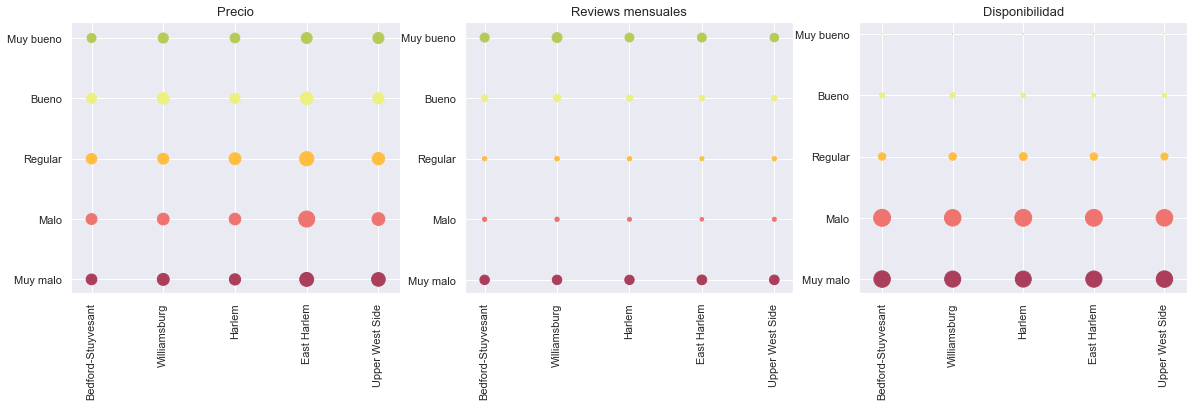

In [18]:
# Se obtienen los tipos de reviews (Muy bueno, bueno, etc) (extraidos de las columnas del top_5) y se invierte (Muy malo, malo, etc) para
# una visualización mas coherente
reviews_grafica = list(top_5.columns)[::-1]
# Se reutilizan los colores empleados en la parte 1, se invierten al igual que las reviews
colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
colors = colors[::-1]

# El nombre de las columnas de las que van a representarse gráficas
graficas = ['price', 'reviews_per_month', 'availability_365']
# El título de dichas gráficas
titles = ['Precio', 'Reviews mensuales', 'Disponibilidad']

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, grafica in enumerate(graficas):

    
    sizes = []
    for review in reviews_grafica:
        # Dado que la grafica tiene 2 indices, se accede a ella especificando el nivel (classification) y el valor (review), el cual irá cambiando
        # en cada iteracion. [grafica] filtra para el tipo de gráfica que se esta ploteando, viene dado por la iteracion del for superior
        sizes.append(datos_top_5.xs(review, level='classification', drop_level = False)[grafica].values)
        # Explicación:
        # La anterior línea de código añade a la lista 'sizes' los valores asociados a un tipo de review para cada barrio para su posterior representación en la grafica.
        # sizes[0][0], para grafica precio, contendría el precio medio de los pisos con reviews 'Muy malas' del barrio de Bedford [0][1] idem para barrio de Williamsburg, etc.
        # sizes[1][0] contendría el precio medio de los pisos con reviews 'Malas' en Bedford, etc.
    
    # Para una mejor visualizacion de la gráfica de las reviews mensuales, dado que el valor es pequeño y no se aprecia, se multiplica
    # por un factor para agrandar el tamaño del punto
    if grafica == 'reviews_per_month':
        sizes = np.array(sizes)*30
        
    for j, (size, color) in enumerate(zip(sizes, colors)):
        # Vamos ploteando nivel a nivel, primero Muy malo, luego Malo, etc.
        x = np.arange(0, len(size), 1)
        y = np.full(len(sizes), j)
        ax[i].scatter(x, y, size, c = color)

    ax[i].set_yticks(np.arange(5))
    ax[i].set_xticks(np.arange(5))
    ax[i].set_xticklabels(top_5.index, rotation = 'vertical')
    ax[i].set_yticklabels(reviews_grafica)

    ax[i].set_title(titles[i], fontsize = 13)
    
plt.show()

Las anteriores gráficas nos muestran, de izquierda a derecha, como se distribuyen el precio, las reviews mensuales y la disponibilidad en función del barrio y la clasificación del lugar, interpretándose el tamaño de la burbuja como mayor o menor precio, menos o más reviews y mayor o menor disponibilidad. El color está asociado al tipo de review, al igual que en la primera gráfica.

<br>Empezando por la gráfica de la izquierda, se puede deducir que el precio del alojamiento entre los alojamientos clasificados como muy buenos y los muy malos no es muy dispar y sin embargo, se aprecia como el precio del alojamiento desciende ligeramente según mejora su clasificación; es probable que aquellos alojamientos clasificados como muy malos o malos fueran caros y no cumplieran las espectativas asociadas a un precio elevado, motivando a los usuarios a dejar una mala review. Por otro lado, aquellos con mejor clasificación tienen precios más reducidos, lo cual indica que probablemente cumplieran las espectativas que los usuarios tenían para precios más ajusados.

<br>En la gráfica del medio se puede apreciar una cierta simetría; parece que los usuarios son más propensos a dejar reviews cuando el alojamiento ha causado una fuerte impresión en ellos, bien por ser un muy buen alojamiento o un alojamiento terrible. Los usuarios tienden a recomendar aquellos alojamientos en los que han disfrutado y a prevenir a otros usuarios sobre alojamientos en los que han tenido una mala experiencia.

<br>La gráfica de la derecha muestra un gradiente pronunciado y de fácil interpretación; la calidad del alojamiento y su disponibilidad va de la mano, siendo la disponibilidad de los mejores casi inapreciable frente a la perfectamente visible disponibilidad de los peores alojamientos.

### 3. Diferencia entre alquilar un piso y una habitación

<i>Una vez obtenida la información del apartado anterior, queremos tratar de entender las
diferencias de precio entre alquilar un apartamento entero y una habitación privada. Usa los diagramas de
cajas donde cada uno de los 5 barrios más populares está representado por una caja y haz una interpretación
de los resultados</i>

In [28]:
datos_top_5 = airbnb.groupby(['neighbourhood', 'room_type']).mean()
datos_top_5 = datos_top_5.loc[list(top_5.index),:]
datos_top_5

price  reviews_per_month  \
neighbourhood      room_type                                        
Bedford-Stuyvesant Entire home/apt  152.197497           1.702392   
                   Private room      68.107230           1.429504   
                   Shared room       39.521127           1.317324   
East Harlem        Entire home/apt  191.571770           1.559091   
                   Private room      88.378099           1.715103   
                   Shared room       58.738095           2.315476   
Harlem             Entire home/apt  173.345848           1.275165   
                   Private room      80.041796           1.379265   
                   Shared room       72.114286           1.524286   
Upper West Side    Entire home/apt  235.813034           0.825406   
                   Private room     103.479924           1.294723   
                   Shared room       74.739130           1.632609   
Williamsburg       Entire home/apt  197.137667           1.087393   
                   Private room      83.486297           1.114857   
                   Shared room       76.333333           0.968095   

                                    availability_365  
neighbourhood      room_type                          
Bedford-Stuyvesant Entire home/apt        123.949235  
                   Private room           120.630515  
                   Shared room            196.521127  
East Harlem        Entire home/apt        101.633971  
                   Private room           101.340909  
                   Shared room             80.285714  
Harlem             Entire home/apt        100.529010  
                   Private room           117.886223  
                   Shared room            134.685714  
Upper West Side    Entire home/apt         99.543803  
                   Private room            90.550669  
                   Shared room            146.695652  
Williamsburg       Entire home/apt         85.502868  
                   Private room            72.094965  
                   Shared room            123.666667